<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Exploration potential for enhanced landing and roving capabilities

Instead of focusing on NASA's Mars 2020 rover, our goal is now to look at the impact on exploration of enhanced rovers' capabilities.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.fuzzy_logic import *
from skdiscovery.utilities.planetary.ellipse_uncertainty import *
from skdiscovery.utilities.planetary.traverse_emulation import *

import matplotlib.pyplot as plt

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389.500 # kilometers

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

## Landing on dusty areas and at higher elevations

Here we want to look at how changing the landing constraints could help to explore more regions of Mars. We use the initial targets of the traverse paths for every scenario computed with the rover speed map where a rover can traverse dusty areas. We will look at the evolution of the landing favorability at those locations when we change the fuzzification of the engineering constraints for landing.

In [4]:
speed_affix = '_DustTraversable'

selection_method = 'Paths'

In [5]:
initial_target_locations = None

if selection_method == 'Threshold':
    raster_locations = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_StandingWater_HesperianNoachian_25' + speed_affix + '.tif')
    raster_locations_array = get_raster_array(raster_locations)

    raster_locations_other = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_StandingWater_EarlyMiddleNoachian_25' + speed_affix + '.tif')
    raster_locations_other_array = get_raster_array(raster_locations_other)
    raster_locations_array[raster_locations_other_array == 0] = 0

    raster_locations_other = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_GroundWater_AllTime_25' + speed_affix + '.tif')
    raster_locations_other_array = get_raster_array(raster_locations_other)
    raster_locations_array[raster_locations_other_array == 0] = 0

    raster_locations_other = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_WaterMagma_AllTime_25' + speed_affix + '.tif')
    raster_locations_other_array = get_raster_array(raster_locations_other)
    raster_locations_array[raster_locations_other_array == 0] = 0

    initial_target_locations = np.where(raster_locations_array == 0)
elif selection_method == 'Paths':
    raster_locations_array = np.ones((master_height, master_width))    

    path_file = 'Results_List_Paths_StandingWater_EarlyMiddleNoachian_25' + speed_affix + '.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    for path in paths_dict:
        raster_locations_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_StandingWater_HesperianNoachian_25' + speed_affix + '.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    for path in paths_dict:
        raster_locations_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_GroundWater_AllTime_25' + speed_affix + '.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    for path in paths_dict:
        raster_locations_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_WaterMagma_AllTime_25' + speed_affix + '.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    for path in paths_dict:
        raster_locations_array[path[0][0][0]] = 0
        
    initial_target_locations = np.where(raster_locations_array == 0)
else:
    print('Unknown method')

We define the varying values for fuzzification. We only look at two variables: the elevation and the thermophysical surface units.

In [6]:
elevation_max_limits = range(-2000, 8100, 100)

drivable_dusty_areas = [0, 1]

In [7]:
raster_elevation = open_raster(base_folder + output_folder + 'MGS_MOLA_Elevation.tif')
raster_elevation_array = get_raster_array(raster_elevation)

raster_thermophy = open_raster(base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif')
raster_thermophy_array = get_raster_array(raster_thermophy)

favorable_indices = np.where((raster_thermophy_array == 2) | 
                             (raster_thermophy_array == 3) | 
                             (raster_thermophy_array == 5) | 
                             (raster_thermophy_array == 6))
nonfavorable_indices = np.where((raster_thermophy_array == 1) | 
                                (raster_thermophy_array == 4) | 
                                (raster_thermophy_array == 7))

We import all the constraints that will not vary.

In [8]:
raster_latitude = open_raster(base_folder + output_folder + 'Other_Data_Latitude.tif')
raster_latitude_array = get_raster_array(raster_latitude)
raster_latitude_array = trapezoidal_function(raster_latitude_array, -45, -30, 30, 45,
                                             bottom_value = 0, plateau_value = 1, nan_value = 0)

raster_std_elevation_1km = open_raster(base_folder + output_folder + 'MGS_MOLA_Std_Elevation_1km.tif')
raster_std_elevation_1km_array = get_raster_array(raster_std_elevation_1km)
raster_std_elevation_1km_array = trapezoidal_function(raster_std_elevation_1km_array, 0, 0, 100, 130,
                                                      bottom_value = 0, plateau_value = 1, nan_value = 0)

raster_std_elevation_2km = open_raster(base_folder + output_folder + 'MGS_MOLA_Std_Elevation_2km.tif')
raster_std_elevation_2km_array = get_raster_array(raster_std_elevation_2km)
raster_std_elevation_2km_array = trapezoidal_function(raster_std_elevation_2km_array, 0, 0, 130, 720,
                                                      bottom_value = 0, plateau_value = 1, nan_value = 0)

raster_slope_1km = open_raster(base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif')
raster_slope_1km_array = get_raster_array(raster_slope_1km)
raster_slope_1km_array = trapezoidal_function(raster_slope_1km_array, -10000, -10000, 2, 2.5,
                                              bottom_value = 0, plateau_value = 1, nan_value = 0)

raster_traverse_hirise_dtm_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_DTM_Rasterized_Footprints.tif')
raster_traverse_hirise_dtm_footprints_array = get_raster_array(raster_traverse_hirise_dtm_footprints)

raster_traverse_hrsc_footprints = open_raster(base_folder + output_folder + 'MEX_HRSC_Rasterized_Footprints.tif')
raster_traverse_hrsc_footprints_array = get_raster_array(raster_traverse_hrsc_footprints)

raster_traverse_hirise_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_Rasterized_Footprints.tif')
raster_traverse_hirise_footprints_array = get_raster_array(raster_traverse_hirise_footprints)

raster_traverse_crism_footprints = open_raster(base_folder + output_folder + 'MRO_CRISM_Rasterized_Footprints.tif')
raster_traverse_crism_footprints_array = get_raster_array(raster_traverse_crism_footprints)

We define the parameters of the landing ellipse to compute the landing favorability.

In [9]:
a = 12.500 # kilometers
b = 10.000 # kilometers
azimuth = 90*np.pi/180

number_of_nodes = 500

longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)
longitude_array = longitude_array*np.pi/180.
latitude_array = latitude_array*np.pi/180.

We perform the analysis.

&#9888; The computation can take several tens of minutes.

In [10]:
%%time

mean_landing_favorability_per_limit = []

for drivable_dusty_area in drivable_dusty_areas:
    
    print('~'*80)
    print('Drivable dusty area:', drivable_dusty_area)

    fuzzified_thermophy_array = np.copy(raster_thermophy_array)
    fuzzified_thermophy_array[favorable_indices] = 1.
    fuzzified_thermophy_array[nonfavorable_indices] = drivable_dusty_area
    fuzzified_thermophy_array[np.isnan(raster_thermophy_array)] = 0.
    
    temp = []

    for elevation_max_limit in elevation_max_limits:

        print('Elevation:', elevation_max_limit)

        elevation_min_limit = elevation_max_limit - 1000

        fuzzified_elevation_array = trapezoidal_function(raster_elevation_array,
                                                         -10000, -10000,
                                                         elevation_min_limit, elevation_max_limit,
                                                         bottom_value = 0, plateau_value = 1, nan_value = 0)

        engineering_constraints_array = algebraic_product(raster_latitude_array,
                                                          fuzzified_elevation_array,
                                                          raster_std_elevation_1km_array,
                                                          raster_std_elevation_2km_array,
                                                          raster_slope_1km_array,
                                                          fuzzified_thermophy_array)
        high_resolution_data_array = union(raster_traverse_hirise_dtm_footprints_array,
                                           raster_traverse_hrsc_footprints_array)
        high_resolution_data_array = gamma_operation(0.9, high_resolution_data_array,
                                                     raster_traverse_hirise_footprints_array)
        landing_array = gamma_operation(0.9, engineering_constraints_array, high_resolution_data_array)

        ellipse_mean_array = np.full((master_height, master_width), np.nan)
        ellipse_stdev_array = np.full((master_height, master_width), np.nan)

        for j, i in np.dstack(initial_target_locations)[0]:
            ellipse_mean_array[j, i], ellipse_stdev_array[j, i] = compute_landing_ellipse_uncertainty(landing_array,
                                                                                                      i,
                                                                                                      j,
                                                                                                      longitude_array, 
                                                                                                      latitude_array, 
                                                                                                      a, 
                                                                                                      b,
                                                                                                      azimuth)

        landing_favorability_array = algebraic_product(ellipse_mean_array, complement(ellipse_stdev_array))

        temp.append([np.mean(landing_favorability_array[initial_target_locations]),
                     np.std(landing_favorability_array[initial_target_locations]),
                     np.min(landing_favorability_array[initial_target_locations]),
                     np.max(landing_favorability_array[initial_target_locations])])
        
    mean_landing_favorability_per_limit.append(temp)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Drivable dusty area: 0
Elevation: -2000
Elevation: -1900
Elevation: -1800
Elevation: -1700
Elevation: -1600
Elevation: -1500
Elevation: -1400
Elevation: -1300
Elevation: -1200
Elevation: -1100
Elevation: -1000
Elevation: -900
Elevation: -800
Elevation: -700
Elevation: -600
Elevation: -500
Elevation: -400
Elevation: -300
Elevation: -200
Elevation: -100
Elevation: 0
Elevation: 100
Elevation: 200
Elevation: 300
Elevation: 400
Elevation: 500
Elevation: 600
Elevation: 700
Elevation: 800
Elevation: 900
Elevation: 1000
Elevation: 1100
Elevation: 1200
Elevation: 1300
Elevation: 1400
Elevation: 1500
Elevation: 1600
Elevation: 1700
Elevation: 1800
Elevation: 1900
Elevation: 2000
Elevation: 2100
Elevation: 2200
Elevation: 2300
Elevation: 2400
Elevation: 2500
Elevation: 2600
Elevation: 2700
Elevation: 2800
Elevation: 2900
Elevation: 3000
Elevation: 3100
Elevation: 3200
Elevation: 3300
Elevation: 3400
Elevation: 3500
E

<IPython.core.display.Javascript object>


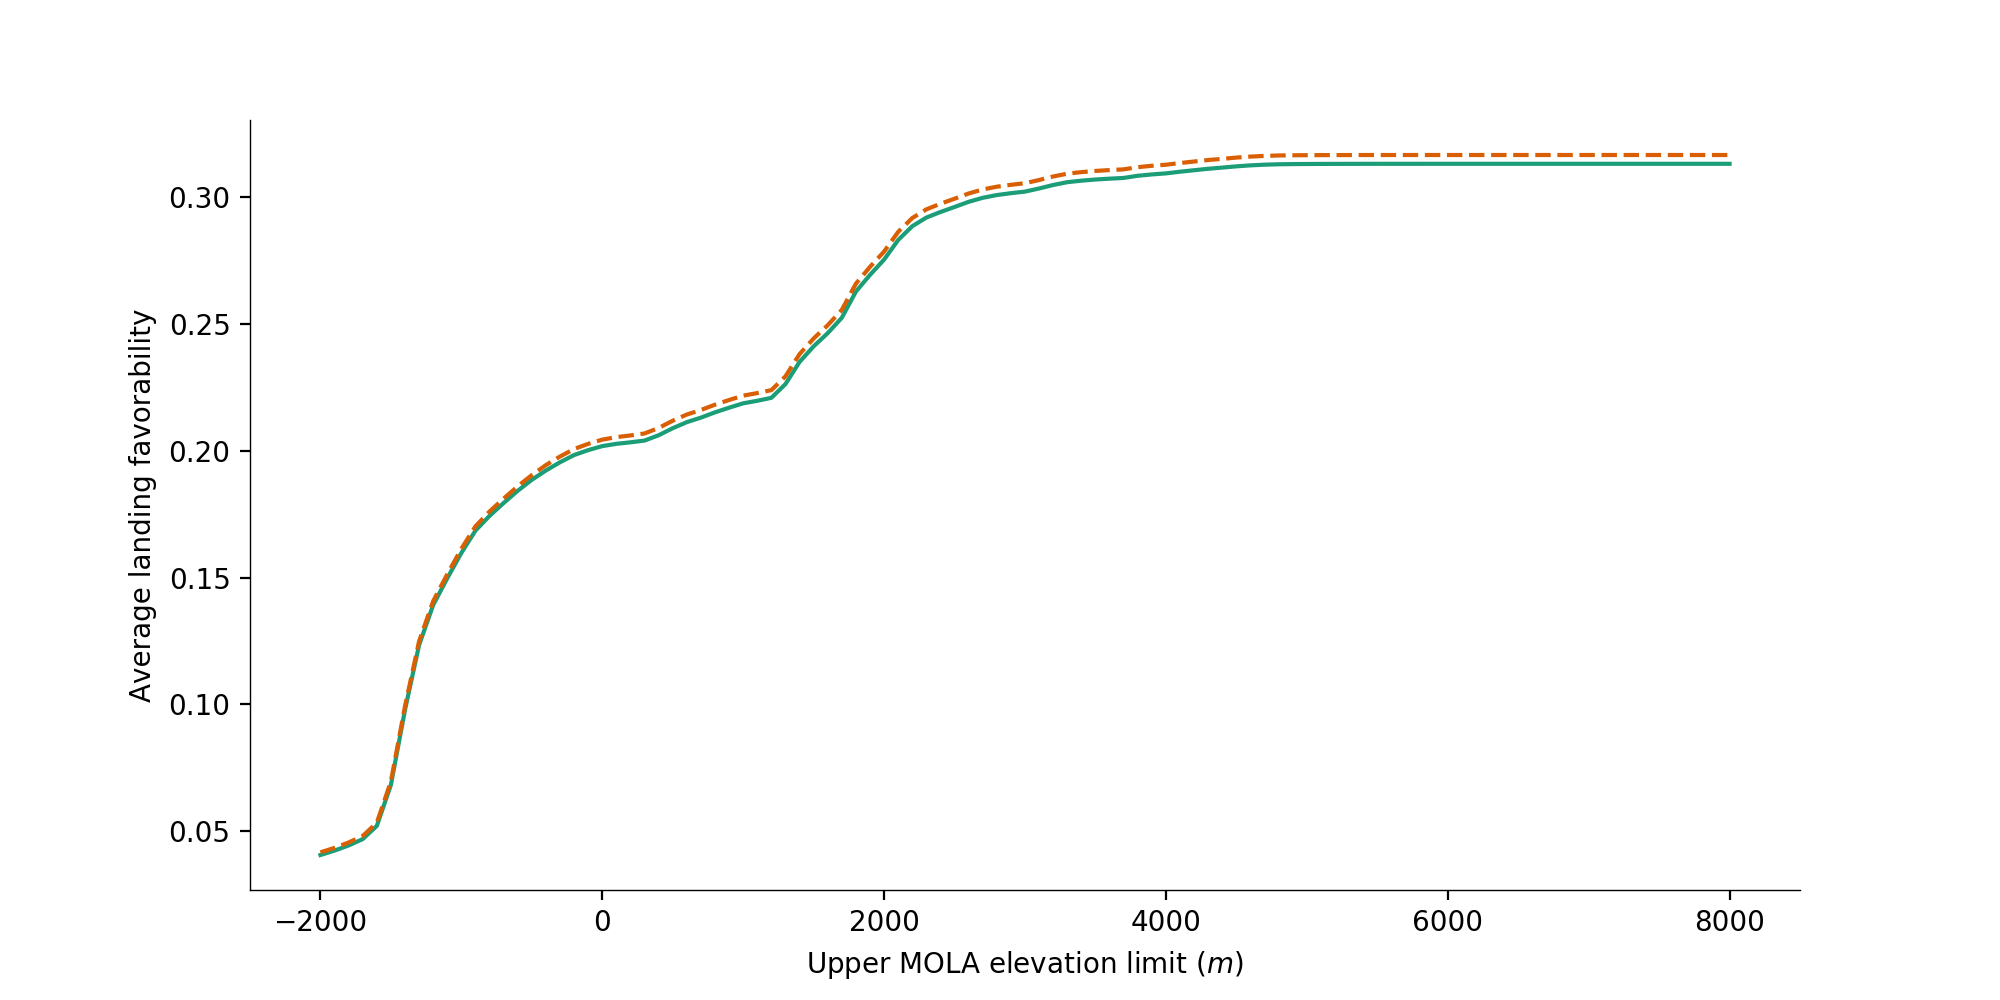

In [11]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)

plt.plot(elevation_max_limits, list(zip(*mean_landing_favorability_per_limit[0]))[0], '#1b9e77')
plt.plot(elevation_max_limits, list(zip(*mean_landing_favorability_per_limit[1]))[0], '#D95F02', linestyle = '--')

plt.xlabel("Upper MOLA elevation limit ($m$)")
plt.ylabel("Average landing favorability")

# Thin the bottom and left axes lines ("spines")
subfigure1.spines['left'].set_linewidth(0.5)
subfigure1.spines['bottom'].set_linewidth(0.5)
# Remove top and right axes lines ("spines")
subfigure1.spines['right'].set_visible(False)
subfigure1.spines['top'].set_visible(False)

# Put the ticks outside
subfigure1.tick_params(direction='out')

# Only show ticks on the left and bottom spines
subfigure1.yaxis.set_ticks_position('left')
subfigure1.xaxis.set_ticks_position('bottom')

plt.show()

We can print the plot values

In [12]:
print('No landing on dust:\n')
for elevation_max_limit, mean_landing_favorability in zip(elevation_max_limits,
                                                          list(zip(*mean_landing_favorability_per_limit[0]))[0]):
    print((elevation_max_limit, mean_landing_favorability), end = '')
print('\n')
print('~'*80, '\n')
print('Landing on dust:\n')
for elevation_max_limit, mean_landing_favorability in zip(elevation_max_limits,
                                                          list(zip(*mean_landing_favorability_per_limit[1]))[0]):
    print((elevation_max_limit, mean_landing_favorability), end = '')

No landing on dust:

(-2000, 0.04050776661549666)(-1900, 0.04224743550006974)(-1800, 0.044282446980376346)(-1700, 0.04678012100545039)(-1600, 0.05199234801881967)(-1500, 0.06819798726345126)(-1400, 0.09778940274636755)(-1300, 0.12337288937865835)(-1200, 0.139157715945888)(-1100, 0.14973089971648748)(-1000, 0.15970977011442922)(-900, 0.1685212916970646)(-800, 0.17434147790528984)(-700, 0.1794130468124164)(-600, 0.18423253902326442)(-500, 0.188573201215989)(-400, 0.19224569794600171)(-300, 0.1954878069003085)(-200, 0.19833900618790032)(-100, 0.2002854249673253)(0, 0.2018631825844307)(100, 0.20276199106681422)(200, 0.2033639234668649)(300, 0.20405220206009864)(400, 0.2061484122847556)(500, 0.2089271173452871)(600, 0.21132070675483083)(700, 0.21310297417473775)(800, 0.21519222912330188)(900, 0.217025282755329)(1000, 0.21875032304029765)(1100, 0.21975081154981776)(1200, 0.220915161700765)(1300, 0.22633991474808235)(1400, 0.23507746224005402)(1500, 0.24123905143719807)(1600, 0.24644542167330

## Longer driving time and improved rover speed

We look at how many more targets become reachable in the traverse paths when increasing the time spent by the rover at driving and the rover's speed. The maximum driving time is increased by 3 minutes at each iteration, until 10 hours.

In [13]:
maximum_driving_times = np.arange(0, 10.05, 0.05).tolist()
speed_affixes = ['_Speed100', '_Speed1000', '_Speed10000']

# maximum_driving_times = np.arange(0, 30, 0.05).tolist()
# speed_affixes = ['_Speed100']

This plot gives an idea of which areas can be reached after 10 hours at the highest possible speeds of this study (~10 km.h<sup>-1</sup>), starting from the sedimentary-rock exposures.

In [14]:
raster_traverse_sedimentary_rock_exposures = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Sedimentary_Rock_Exposures_Speed10000.tif')
raster_traverse_sedimentary_rock_exposures_array = get_raster_array(raster_traverse_sedimentary_rock_exposures)

raster_traverse_sedimentary_rock_exposures_array = trapezoidal_function(raster_traverse_sedimentary_rock_exposures_array[0]*24.65979,
                                                                        0, 0, maximum_driving_times[-1], maximum_driving_times[-1],
                                                                        bottom_value = 0.1, plateau_value = 1, nan_value = 0)

/home/grongier/Packages/skdiscovery-dev/skdiscovery/utilities/planetary/fuzzy_logic.py:67: RuntimeWarning: invalid value encountered in greater_equal
  indices = np.where(np.logical_and(x_start_plateau <= raster_array,
/home/grongier/Packages/skdiscovery-dev/skdiscovery/utilities/planetary/fuzzy_logic.py:68: RuntimeWarning: invalid value encountered in less_equal
  raster_array <= x_end_plateau))


<IPython.core.display.Javascript object>


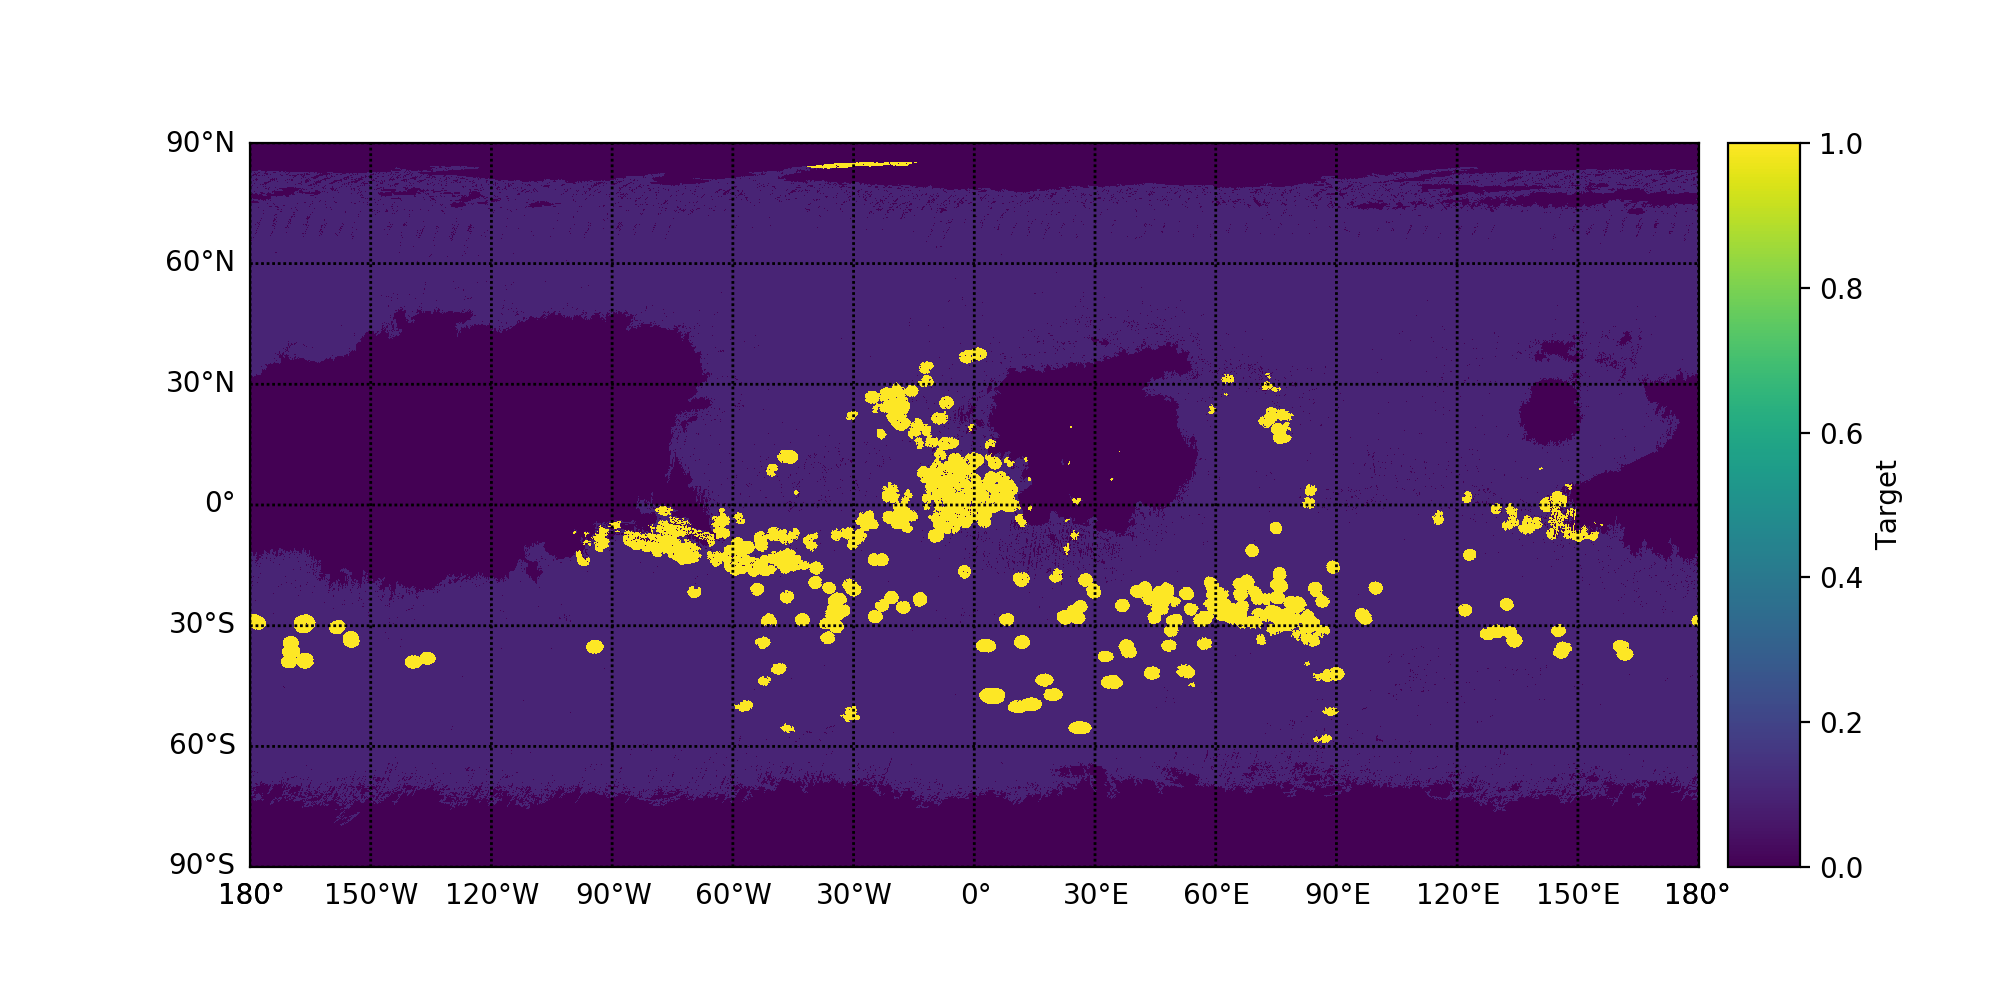

In [15]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_traverse_sedimentary_rock_exposures_array, 'Target')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

We perform the analysis by getting some characteristics of the traverse paths for each rover speed map and maximum driving time. The travel time maps must first be converted from sols to hours.

&#9888; The computation time can take several tens of hours.

In [16]:
def load_scientific_targets(speed_affix):
    raster_traverse_sedimentary_rock_exposures = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Sedimentary_Rock_Exposures' + speed_affix + '.tif')
    raster_traverse_sedimentary_rock_exposures_array = get_raster_array(raster_traverse_sedimentary_rock_exposures)
    raster_traverse_sedimentary_rock_exposures_array[0,:,:] = raster_traverse_sedimentary_rock_exposures_array[0,:,:]*24.65979
    raster_traverse_valley_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Valley_Networks' + speed_affix + '.tif')
    raster_traverse_valley_networks_array = get_raster_array(raster_traverse_valley_networks)
    raster_traverse_valley_networks_array[0,:,:] = raster_traverse_valley_networks_array[0,:,:]*24.65979
    raster_traverse_alluvial_fans = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Alluvial_Fans' + speed_affix + '.tif')
    raster_traverse_alluvial_fans_array = get_raster_array(raster_traverse_alluvial_fans)
    raster_traverse_alluvial_fans_array[0,:,:] = raster_traverse_alluvial_fans_array[0,:,:]*24.65979
    raster_traverse_subaqueous_fans = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Subaqueous_Fans' + speed_affix + '.tif')
    raster_traverse_subaqueous_fans_array = get_raster_array(raster_traverse_subaqueous_fans)
    raster_traverse_subaqueous_fans_array[0,:,:] = raster_traverse_subaqueous_fans_array[0,:,:]*24.65979
    raster_traverse_deltaic_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Deltaic_Deposits' + speed_affix + '.tif')
    raster_traverse_deltaic_deposits_array = get_raster_array(raster_traverse_deltaic_deposits)
    raster_traverse_deltaic_deposits_array[0,:,:] = raster_traverse_deltaic_deposits_array[0,:,:]*24.65979
    raster_traverse_open_basin_lakes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Open_Basin_Lakes' + speed_affix + '.tif')
    raster_traverse_open_basin_lakes_array = get_raster_array(raster_traverse_open_basin_lakes)
    raster_traverse_open_basin_lakes_array[0,:,:] = raster_traverse_open_basin_lakes_array[0,:,:]*24.65979
    raster_traverse_closed_basin_lakes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Closed_Basin_Lakes' + speed_affix + '.tif')
    raster_traverse_closed_basin_lakes_array = get_raster_array(raster_traverse_closed_basin_lakes)
    raster_traverse_closed_basin_lakes_array[0,:,:] = raster_traverse_closed_basin_lakes_array[0,:,:]*24.65979
    raster_traverse_channels_no_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Channels_Not_Valleys' + speed_affix + '.tif')
    raster_traverse_channels_no_valleys_array = get_raster_array(raster_traverse_channels_no_valleys)
    raster_traverse_channels_no_valleys_array[0,:,:] = raster_traverse_channels_no_valleys_array[0,:,:]*24.65979
    raster_traverse_outflow_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Outflow_Channels' + speed_affix + '.tif')
    raster_traverse_outflow_channels_array = get_raster_array(raster_traverse_outflow_channels)
    raster_traverse_outflow_channels_array[0,:,:] = raster_traverse_outflow_channels_array[0,:,:]*24.65979
    raster_outflow_channels_large_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Outflow_Channels_Large_Valleys' + speed_affix + '.tif')
    raster_outflow_channels_large_valleys_array = get_raster_array(raster_outflow_channels_large_valleys)
    raster_outflow_channels_large_valleys_array[0,:,:] = raster_outflow_channels_large_valleys_array[0,:,:]*24.65979
    raster_traverse_groundwater_valley_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Groundwater_Valley_Networks' + speed_affix + '.tif')
    raster_traverse_groundwater_valley_networks_array = get_raster_array(raster_traverse_groundwater_valley_networks)
    raster_traverse_groundwater_valley_networks_array[0,:,:] = raster_traverse_groundwater_valley_networks_array[0,:,:]*24.65979
    raster_traverse_pit_crater_chains = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Pit_crater_Chains' + speed_affix + '.tif')
    raster_traverse_pit_crater_chains_array = get_raster_array(raster_traverse_pit_crater_chains)
    raster_traverse_pit_crater_chains_array[0,:,:] = raster_traverse_pit_crater_chains_array[0,:,:]*24.65979
    raster_traverse_graben_axes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Graben_Axes' + speed_affix + '.tif')
    raster_traverse_graben_axes_array = get_raster_array(raster_traverse_graben_axes)
    raster_traverse_graben_axes_array[0,:,:] = raster_traverse_graben_axes_array[0,:,:]*24.65979
    raster_traverse_hydrous_mineral_exposures = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Hydrous_Mineral_Exposures' + speed_affix + '.tif')
    raster_traverse_hydrous_mineral_exposures_array = get_raster_array(raster_traverse_hydrous_mineral_exposures)
    raster_traverse_hydrous_mineral_exposures_array[0,:,:] = raster_traverse_hydrous_mineral_exposures_array[0,:,:]*24.65979
    raster_traverse_chloride_materials = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Chloride_Materials' + speed_affix + '.tif')
    raster_traverse_chloride_materials_array = get_raster_array(raster_traverse_chloride_materials)
    raster_traverse_chloride_materials_array[0,:,:] = raster_traverse_chloride_materials_array[0,:,:]*24.65979
    raster_traverse_carbonate_rocks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Carbonate_Rocks' + speed_affix + '.tif')
    raster_traverse_carbonate_rocks_array = get_raster_array(raster_traverse_carbonate_rocks)
    raster_traverse_carbonate_rocks_array[0,:,:] = raster_traverse_carbonate_rocks_array[0,:,:]*24.65979
    raster_traverse_potential_hydrothermal_systems = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Potential_Hydrothermal_Systems' + speed_affix + '.tif')
    raster_traverse_potential_hydrothermal_systems_array = get_raster_array(raster_traverse_potential_hydrothermal_systems)
    raster_traverse_potential_hydrothermal_systems_array[0,:,:] = raster_traverse_potential_hydrothermal_systems_array[0,:,:]*24.65979
    raster_traverse_volcanoes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Volcanoes' + speed_affix + '.tif')
    raster_traverse_volcanoes_array = get_raster_array(raster_traverse_volcanoes)
    raster_traverse_volcanoes_array[0,:,:] = raster_traverse_volcanoes_array[0,:,:]*24.65979
    raster_traverse_calderas = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Calderas' + speed_affix + '.tif')
    raster_traverse_calderas_array = get_raster_array(raster_traverse_calderas)
    raster_traverse_calderas_array[0,:,:] = raster_traverse_calderas_array[0,:,:]*24.65979
    raster_traverse_tharsis_vents = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Tharsis_Vents' + speed_affix + '.tif')
    raster_traverse_tharsis_vents_array = get_raster_array(raster_traverse_tharsis_vents)
    raster_traverse_tharsis_vents_array[0,:,:] = raster_traverse_tharsis_vents_array[0,:,:]*24.65979
    raster_traverse_hesperian_noachian_contacts = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Hesperian_Noachian_Contacts_Targets_Units' + speed_affix + '.tif')
    raster_traverse_hesperian_noachian_contacts_array = get_raster_array(raster_traverse_hesperian_noachian_contacts)
    raster_traverse_hesperian_noachian_contacts_array[0,:,:] = raster_traverse_hesperian_noachian_contacts_array[0,:,:]*24.65979
    raster_traverse_early_middle_noachian_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Early_Middle_Noachian_Targets_Units' + speed_affix + '.tif')
    raster_traverse_early_middle_noachian_units_array = get_raster_array(raster_traverse_early_middle_noachian_units)
    raster_traverse_early_middle_noachian_units_array[0,:,:] = raster_traverse_early_middle_noachian_units_array[0,:,:]*24.65979
    raster_traverse_amazonian_hesperian_volcanic_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Amazonian_Hesperian_Volcanic_Targets_Units' + speed_affix + '.tif')
    raster_traverse_amazonian_hesperian_volcanic_units_array = get_raster_array(raster_traverse_amazonian_hesperian_volcanic_units)
    raster_traverse_amazonian_hesperian_volcanic_units_array[0,:,:] = raster_traverse_amazonian_hesperian_volcanic_units_array[0,:,:]*24.65979
    raster_traverse_noachian_volcanic_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Noachian_Volcanic_Targets_Units' + speed_affix + '.tif')
    raster_traverse_noachian_volcanic_units_array = get_raster_array(raster_traverse_noachian_volcanic_units)
    raster_traverse_noachian_volcanic_units_array[0,:,:] = raster_traverse_noachian_volcanic_units_array[0,:,:]*24.65979
    raster_traverse_dune_fields = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Dune_Fields' + speed_affix + '.tif')
    raster_traverse_dune_fields_array = get_raster_array(raster_traverse_dune_fields)
    raster_traverse_dune_fields_array[0,:,:] = raster_traverse_dune_fields_array[0,:,:]*24.65979
    raster_traverse_gullies = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Gullies' + speed_affix + '.tif')
    raster_traverse_gullies_array = get_raster_array(raster_traverse_gullies)
    raster_traverse_gullies_array[0,:,:] = raster_traverse_gullies_array[0,:,:]*24.65979
    raster_traverse_rsl = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_RSL' + speed_affix + '.tif')
    raster_traverse_rsl_array = get_raster_array(raster_traverse_rsl)
    raster_traverse_rsl_array[0,:,:] = raster_traverse_rsl_array[0,:,:]*24.65979
    raster_traverse_recent_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Recent_Craters' + speed_affix + '.tif')
    raster_traverse_recent_craters_array = get_raster_array(raster_traverse_recent_craters)
    raster_traverse_recent_craters_array[0,:,:] = raster_traverse_recent_craters_array[0,:,:]*24.65979
    raster_traverse_fresh_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Fresh_Craters' + speed_affix + '.tif')
    raster_traverse_fresh_craters_array = get_raster_array(raster_traverse_fresh_craters)
    raster_traverse_fresh_craters_array[0,:,:] = raster_traverse_fresh_craters_array[0,:,:]*24.65979
    raster_traverse_deep_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Deep_Craters' + speed_affix + '.tif')
    raster_traverse_deep_craters_array = get_raster_array(raster_traverse_deep_craters)
    raster_traverse_deep_craters_array[0,:,:] = raster_traverse_deep_craters_array[0,:,:]*24.65979
    raster_traverse_large_degraded_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Large_Degraded_Craters.tif')
    raster_traverse_large_degraded_craters_array = get_raster_array(raster_traverse_large_degraded_craters)
    raster_traverse_large_degraded_craters_array[0,:,:] = raster_traverse_large_degraded_craters_array[0,:,:]*24.65979
    raster_traverse_crater_wall_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Wall_Channels' + speed_affix + '.tif')
    raster_traverse_crater_wall_channels_array = get_raster_array(raster_traverse_crater_wall_channels)
    raster_traverse_crater_wall_channels_array[0,:,:] = raster_traverse_crater_wall_channels_array[0,:,:]*24.65979
    raster_traverse_crater_floor_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Channels' + speed_affix + '.tif')
    raster_traverse_crater_floor_channels_array = get_raster_array(raster_traverse_crater_floor_channels)
    raster_traverse_crater_floor_channels_array[0,:,:] = raster_traverse_crater_floor_channels_array[0,:,:]*24.65979
    raster_traverse_crater_floor_valley_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Valley_Deposits' + speed_affix + '.tif')
    raster_traverse_crater_floor_valley_deposits_array = get_raster_array(raster_traverse_crater_floor_valley_deposits)
    raster_traverse_crater_floor_valley_deposits_array[0,:,:] = raster_traverse_crater_floor_valley_deposits_array[0,:,:]*24.65979
    raster_traverse_crater_floor_landslide_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Landslide_Deposits' + speed_affix + '.tif')
    raster_traverse_crater_floor_landslide_deposits_array = get_raster_array(raster_traverse_crater_floor_landslide_deposits)
    raster_traverse_crater_floor_landslide_deposits_array[0,:,:] = raster_traverse_crater_floor_landslide_deposits_array[0,:,:]*24.65979
    raster_traverse_crater_floor_tectonics = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Tectonics' + speed_affix + '.tif')
    raster_traverse_crater_floor_tectonics_array = get_raster_array(raster_traverse_crater_floor_tectonics)
    raster_traverse_crater_floor_tectonics_array[0,:,:] = raster_traverse_crater_floor_tectonics_array[0,:,:]*24.65979
    raster_traverse_crater_floor_fractured = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Fractured' + speed_affix + '.tif')
    raster_traverse_crater_floor_fractured_array = get_raster_array(raster_traverse_crater_floor_fractured)
    raster_traverse_crater_floor_fractured_array[0,:,:] = raster_traverse_crater_floor_fractured_array[0,:,:]*24.65979
    raster_traverse_crater_floor_dunes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Dunes' + speed_affix + '.tif')
    raster_traverse_crater_floor_dunes_array = get_raster_array(raster_traverse_crater_floor_dunes)
    raster_traverse_crater_floor_dunes_array[0,:,:] = raster_traverse_crater_floor_dunes_array[0,:,:]*24.65979
    raster_traverse_craters_sandbars = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Craters_Sandbars' + speed_affix + '.tif')
    raster_traverse_craters_sandbars_array = get_raster_array(raster_traverse_craters_sandbars)
    raster_traverse_craters_sandbars_array[0,:,:] = raster_traverse_craters_sandbars_array[0,:,:]*24.65979
    raster_traverse_lobate_flows = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Lobate_Flows' + speed_affix + '.tif')
    raster_traverse_lobate_flows_array = get_raster_array(raster_traverse_lobate_flows)
    raster_traverse_lobate_flows_array[0,:,:] = raster_traverse_lobate_flows_array[0,:,:]*24.65979
    raster_traverse_rilles = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Rilles' + speed_affix + '.tif')
    raster_traverse_rilles_array = get_raster_array(raster_traverse_rilles)
    raster_traverse_rilles_array[0,:,:] = raster_traverse_rilles_array[0,:,:]*24.65979
    raster_traverse_ridges = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Ridges' + speed_affix + '.tif')
    raster_traverse_ridges_array = get_raster_array(raster_traverse_ridges)
    raster_traverse_ridges_array[0,:,:] = raster_traverse_ridges_array[0,:,:]*24.65979
    raster_traverse_scarps = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Scarps' + speed_affix + '.tif')
    raster_traverse_scarps_array = get_raster_array(raster_traverse_scarps)
    raster_traverse_scarps_array[0,:,:] = raster_traverse_scarps_array[0,:,:]*24.65979
    raster_traverse_glacial_features = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glacial_Features' + speed_affix + '.tif')
    raster_traverse_glacial_features_array = get_raster_array(raster_traverse_glacial_features)
    raster_traverse_glacial_features_array[0,:,:] = raster_traverse_glacial_features_array[0,:,:]*24.65979
    raster_traverse_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glacier_like_Forms' + speed_affix + '.tif')
    raster_traverse_glacier_like_forms_array = get_raster_array(raster_traverse_glacier_like_forms)
    raster_traverse_glacier_like_forms_array[0,:,:] = raster_traverse_glacier_like_forms_array[0,:,:]*24.65979
    raster_traverse_crevassed_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crevassed_Glacier_like_Forms' + speed_affix + '.tif')
    raster_traverse_crevassed_glacier_like_forms_array = get_raster_array(raster_traverse_crevassed_glacier_like_forms)
    raster_traverse_crevassed_glacier_like_forms_array[0,:,:] = raster_traverse_crevassed_glacier_like_forms_array[0,:,:]*24.65979
    raster_traverse_recessional_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Recessional_Glacier_like_Forms' + speed_affix + '.tif')
    raster_traverse_recessional_glacier_like_forms_array = get_raster_array(raster_traverse_recessional_glacier_like_forms)
    raster_traverse_recessional_glacier_like_forms_array[0,:,:] = raster_traverse_recessional_glacier_like_forms_array[0,:,:]*24.65979
    raster_traverse_tropical_mountain_glaciers = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Tropical_Mountain_Glaciers' + speed_affix + '.tif')
    raster_traverse_tropical_mountain_glaciers_array = get_raster_array(raster_traverse_tropical_mountain_glaciers)
    raster_traverse_tropical_mountain_glaciers_array[0,:,:] = raster_traverse_tropical_mountain_glaciers_array[0,:,:]*24.65979
    raster_traverse_glaciofluvial_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glaciofluvial_Valleys' + speed_affix + '.tif')
    raster_traverse_glaciofluvial_valleys_array = get_raster_array(raster_traverse_glaciofluvial_valleys)
    raster_traverse_glaciofluvial_valleys_array[0,:,:] = raster_traverse_glaciofluvial_valleys_array[0,:,:]*24.65979
    raster_traverse_young_deltas = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Young_Deltas' + speed_affix + '.tif')
    raster_traverse_young_deltas_array = get_raster_array(raster_traverse_young_deltas)
    raster_traverse_young_deltas_array[0,:,:] = raster_traverse_young_deltas_array[0,:,:]*24.65979
    raster_traverse_dissected_mantle = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Dissected_Mantle' + speed_affix + '.tif')
    raster_traverse_dissected_mantle_array = get_raster_array(raster_traverse_dissected_mantle)
    raster_traverse_dissected_mantle_array[0,:,:] = raster_traverse_dissected_mantle_array[0,:,:]*24.65979
    raster_traverse_slope_streaks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Slope_Streaks' + speed_affix + '.tif')
    raster_traverse_slope_streaks_array = get_raster_array(raster_traverse_slope_streaks)
    raster_traverse_slope_streaks_array[0,:,:] = raster_traverse_slope_streaks_array[0,:,:]*24.65979
    raster_traverse_wrinkle_ridges = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Wrinkle_Ridges' + speed_affix + '.tif')
    raster_traverse_wrinkle_ridges_array = get_raster_array(raster_traverse_wrinkle_ridges)
    raster_traverse_wrinkle_ridges_array[0,:,:] = raster_traverse_wrinkle_ridges_array[0,:,:]*24.65979
    raster_traverse_yardangs = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Yardangs' + speed_affix + '.tif')
    raster_traverse_yardangs_array = get_raster_array(raster_traverse_yardangs)
    raster_traverse_yardangs_array[0,:,:] = raster_traverse_yardangs_array[0,:,:]*24.65979
    raster_traverse_poly_ridge_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Polygonal_Ridge_Networks' + speed_affix + '.tif')
    raster_traverse_poly_ridge_networks_array = get_raster_array(raster_traverse_poly_ridge_networks)
    raster_traverse_poly_ridge_networks_array[0,:,:] = raster_traverse_poly_ridge_networks_array[0,:,:]*24.65979

    targets_and_scenarios = [# Hydrous minerals
                             [raster_traverse_hydrous_mineral_exposures_array, "Hydrous-mineral exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                             [raster_traverse_chloride_materials_array, "Chloride exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                             [raster_traverse_carbonate_rocks_array, "Carbonate exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                             # Sedimentary structures
                             [raster_traverse_sedimentary_rock_exposures_array, "Sedimentary-rock exposures", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_valley_networks_array, "Valley networks", (4, 1, 4, 1, 9, 5, 3, 0)],
                             [raster_traverse_glaciofluvial_valleys_array, "Glaciofluvial valleys", (4, 1, 4, 1, 9, 5, 3, 0)],
                             [raster_traverse_crater_wall_channels_array, "Crater-wall channels", (4, 1, 4, 1, 9, 5, 3, 0)],
                             [raster_traverse_crater_floor_channels_array, "Crater-floor channels", (4, 1, 4, 1, 9, 5, 3, 0)],
                             [raster_traverse_alluvial_fans_array, "Alluvial fans", (4, 1, 4, 1, 9, 5, 3, 0)],
                             [raster_traverse_deltaic_deposits_array, "Deltaic deposits", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_young_deltas_array, "Young deltas", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_subaqueous_fans_array, "Subaqueous fans", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_crater_floor_valley_deposits_array, "Crater-floor valley deposits", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_open_basin_lakes_array, "Open-basin lakes", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_closed_basin_lakes_array, "Closed-basin lakes", (2, 0, 2, 0, 3, 1, 3, 0)],
                             [raster_traverse_channels_no_valleys_array, "Channels (not valleys)", (9, 5, 9, 5, 3, 1, 3, 0)],
                             [raster_traverse_outflow_channels_array, "Outflow channels", (9, 5, 9, 5, 3, 1, 3, 0)],
                             [raster_outflow_channels_large_valleys_array, "Outflow channels and large valleys", (9, 5, 9, 5, 3, 1, 3, 0)],
                             [raster_traverse_groundwater_valley_networks_array, "Groundwater-controlled valley networks", (9, 5, 9, 5, 3, 1, 3, 0)],
                             [raster_traverse_craters_sandbars_array, "Craters with sandbars", (9, 5, 9, 5, 3, 1, 3, 0)],
                             [raster_traverse_crater_floor_landslide_deposits_array, "Crater-floor landslide deposits", (16, 8, 16, 8, 14, 8, 12, 5)],
                             [raster_traverse_gullies_array, "Gullies", (16, 8, 16, 8, 14, 8, 12, 5)],
                             [raster_traverse_rsl_array, "Recurring Slope Lineae", (16, 8, 16, 8, 14, 8, 12, 5)],
                             [raster_traverse_slope_streaks_array, "Slope streaks", (16, 8, 16, 8, 14, 8, 12, 5)],
                             [raster_traverse_glacial_features_array, "Glacial features", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_glacier_like_forms_array, "Glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_crevassed_glacier_like_forms_array, "Crevassed glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_recessional_glacier_like_forms_array, "Recessional glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_tropical_mountain_glaciers_array, "Tropical mountain glaciers", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_dissected_mantle_array, "Dissected mantle", (12, 6, 12, 6, 10, 6, 8, 3)],
                             [raster_traverse_dune_fields_array, "Dune fields", (15, 8, 15, 8, 13, 8, 11, 5)],
                             [raster_traverse_crater_floor_dunes_array, "Crater-floor dunes", (15, 8, 15, 8, 13, 8, 11, 5)],
                             [raster_traverse_yardangs_array, "Yardangs", (15, 8, 15, 8, 13, 8, 11, 5)],
                             # Volcanic, tectonic, and impact structures
                             [raster_traverse_volcanoes_array, "Volcanoes", (5, 2, 5, 2, 4, 2, 2, 0)],
                             [raster_traverse_calderas_array, "Calderas", (5, 2, 5, 2, 4, 2, 2, 0)],
                             [raster_traverse_tharsis_vents_array, "Tharsis vents", (5, 2, 5, 2, 4, 2, 2, 0)],
                             [raster_traverse_rilles_array, "Rilles", (5, 2, 5, 2, 4, 2, 2, 0)],
                             [raster_traverse_lobate_flows_array, "Lobate flows", (5, 2, 5, 2, 4, 2, 2, 0)],
                             [raster_traverse_amazonian_hesperian_volcanic_units_array, "Hes. to Am. volcanic units", (6, 3, 6, 3, 5, 3, 2, 0)],
                             [raster_traverse_noachian_volcanic_units_array, "Noa. volcanic units", (6, 3, 6, 3, 5, 3, 2, 0)],
                             [raster_traverse_graben_axes_array, "Graben axes", (11, 5, 11, 5, 8, 5, 6, 1)],
                             [raster_traverse_pit_crater_chains_array, "Pit-crater chains", (11, 5, 11, 5, 8, 5, 6, 1)],
                             [raster_traverse_wrinkle_ridges_array, "Wrinkle ridges", (11, 5, 11, 5, 8, 5, 6, 1)],
                             [raster_traverse_crater_floor_tectonics_array, "Crater-floor tectonics", (11, 5, 11, 5, 8, 5, 6, 1)],
                             [raster_traverse_crater_floor_fractured_array, "Fractured crater-floors", (11, 5, 11, 5, 8, 5, 6, 1)],
                             [raster_traverse_recent_craters_array, "Recent craters", (14, 8, 14, 8, 12, 8, 10, 5)],
                             [raster_traverse_fresh_craters_array, "Fresh craters", (14, 8, 14, 8, 12, 8, 10, 5)],
                             [raster_traverse_deep_craters_array, "Deep craters", (7, 4, 7, 4, 2, 0, 7, 2)],
                             [raster_traverse_large_degraded_craters_array, "Large degraded craters", (8, 4, 8, 4, 6, 4, 5, 1)],
                             [raster_traverse_potential_hydrothermal_systems_array, "Potential hydrothermal systems", (10, 5, 10, 5, 7, 5, 4, 1)],
                             # Structures with multiple potential origins
                             [raster_traverse_poly_ridge_networks_array, "Polygonal-ridge networks", (13, 7, 13, 7, 11, 7, 9, 4)],
                             [raster_traverse_scarps_array, "Scarps", (13, 7, 13, 7, 11, 7, 9, 4)],
                             [raster_traverse_ridges_array, "Ridges", (13, 7, 13, 7, 11, 7, 9, 4)],
                             # Time constraints
                             [raster_traverse_hesperian_noachian_contacts_array, "Noa.--Hes. contacts", (None, None, 3, 0, None, None, None, None)],
                             [raster_traverse_early_middle_noachian_units_array, "Early to Middle Noa. units", (3, 0, None, None, None, None, None, None)]]

    return targets_and_scenarios

def load_high_resolution_data():
    raster_traverse_hirise_dtm_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_DTM_Rasterized_Footprints.tif')
    raster_traverse_hirise_dtm_footprints_array = get_raster_array(raster_traverse_hirise_dtm_footprints)
    raster_traverse_hrsc_footprints = open_raster(base_folder + output_folder + 'MEX_HRSC_Rasterized_Footprints.tif')
    raster_traverse_hrsc_footprints_array = get_raster_array(raster_traverse_hrsc_footprints)
    raster_traverse_hirise_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_Rasterized_Footprints.tif')
    raster_traverse_hirise_footprints_array = get_raster_array(raster_traverse_hirise_footprints)
    raster_traverse_crism_footprints = open_raster(base_folder + output_folder + 'MRO_CRISM_Rasterized_Footprints.tif')
    raster_traverse_crism_footprints_array = get_raster_array(raster_traverse_crism_footprints)
    
    high_resolution_data = [[raster_traverse_hirise_dtm_footprints_array, "HiRISE DTM", "elevation", 1],
                            [raster_traverse_hrsc_footprints_array, "HRSC", "elevation", 1],
                            [raster_traverse_hirise_footprints_array, "HiRISE", "visible", 2],
                            [raster_traverse_crism_footprints_array, "CRISM", "spectral", 3]]
    return high_resolution_data

In [17]:
from sklearn.externals.joblib import Parallel, delayed

def identify_neighbors_for_multiprocessing(cells):
    neighbors = defaultdict(list)

    for target in cells:
        target_neighbors = defaultdict(list)
        for k, k_array in enumerate(target_arrays):
            if k not in target_types_at_cells[target] and math.isnan(k_array[0, target[0], target[1]]) == False:
                neighbor = (int(k_array[1, target[0], target[1]]), int(k_array[2, target[0], target[1]]))
                target_neighbors[neighbor].append(k_array[0, target[0], target[1]])

                for l in target_types_at_cells[target]:
                    if (target_arrays[l][1, neighbor[0], neighbor[1]], target_arrays[l][2, neighbor[0], neighbor[1]]) == target:
                        target_neighbors[neighbor].append(target_arrays[l][0, neighbor[0], neighbor[1]])
        for neighbor in target_neighbors:
            if any(time <= maximum_driving_times[-1] for time in target_neighbors[neighbor]):
                neighbors[(target, neighbor)] = target_neighbors[neighbor]

    return neighbors

def compute_traverse_paths_for_multiprocessing(threshold_targets):

    traverse_paths = defaultdict(list)
    
    for target in threshold_targets:

        initial_path = [((target, target_type), 0.) for target_type in target_types_at_cells[target]]
        open_paths = deque([initial_path])
        final_paths = [[] for scenario in scenarios_priorities]

        while open_paths:

            current_path = open_paths.pop()
            last_cell = current_path[-1][0][0]
            neighborhood = neighborhoods.get(last_cell)

            was_neighbor_added = False
            if neighborhood is not None:
                for neighbor in neighborhood:
                    if check_path_validity(current_path,
                                           neighbor,
                                           maximum_driving_time) == True:
                        new_path = list(current_path)
                        for target_type in target_types_at_cells[neighbor[0]]:
                            new_path.append(((neighbor[0], target_type),
                                              current_path[-1][1] + neighbor[1]))
                        open_paths.append(new_path)
                        was_neighbor_added = True
            if was_neighbor_added == False:
                scenarios_visited_groups_per_priorities, scenarios_path_duration = are_all_high_priority_in_path(current_path,
                                                                                                                 scenarios_groups_per_priority,
                                                                                                                 scenarios_target_priorities,
                                                                                                                 scenarios_target_groups)

                path_ranks = compute_path_rank(current_path,
                                               scenarios_visited_groups_per_priorities,
                                               scenarios_path_duration,
                                               maximum_driving_time,
                                               scenarios_target_priorities,
                                               scenarios_target_groups,
                                               scenarios_priorities,
                                               scenarios_groups_per_priority,
                                               high_resolution_arrays,
                                               rad_longitude_array,
                                               rad_latitude_array,
                                               mars_radius,
                                               group_weights,
                                               number_weight,
                                               data_weight,
                                               sinuosity_weight,
                                               duration_weight)

                for scenario, rank in enumerate(path_ranks):
                    if rank is not None:
                        final_paths[scenario].append((rank, scenarios_path_duration[scenario], current_path))
                    
        for scenario, paths in enumerate(final_paths):
            if paths:
                sorted_paths = sorted(paths)
                traverse_paths[tuple(sorted_paths[-1][2])].append((sorted_paths[-1][0],
                                                                   sorted_paths[-1][1],
                                                                   scenario))
                        
    return traverse_paths

In [18]:
number_of_chunks = 20

reachable_features = []

In [19]:
%%time

longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)
rad_longitude_array = longitude_array*np.pi/180.
rad_latitude_array = latitude_array*np.pi/180.

for speed_affix in speed_affixes:
    
    print('~'*80)
    print('Speed:', speed_affix)

    targets_and_scenarios = load_scientific_targets(speed_affix)
    target_arrays = list(zip(*targets_and_scenarios))[0]
    target_names = list(zip(*targets_and_scenarios))[1]
    scenarios_target_groups = []
    scenarios_target_priorities = []
    for groups_and_priorities in list(zip(*targets_and_scenarios))[2]:
        temp_groups = []
        temp_priorities = []
        for i in range(0, len(groups_and_priorities), 2):
            temp_groups.append(groups_and_priorities[i])
            temp_priorities.append(groups_and_priorities[i + 1])
        scenarios_target_groups.append(temp_groups)
        scenarios_target_priorities.append(temp_priorities)
    scenarios_target_groups = [list(scenario) for scenario in zip(*scenarios_target_groups)]
    scenarios_target_priorities = [list(scenario) for scenario in zip(*scenarios_target_priorities)]

    scenarios_priorities = [list(set([priority for priority in target_priorities if priority is not None]))
                            for target_priorities in scenarios_target_priorities]

    scenarios_groups_per_priority = [[set() for priority in target_priorities]
                                     for target_priorities in scenarios_priorities]
    for scenario in range(len(scenarios_priorities)):
        for group, priority in zip(scenarios_target_groups[scenario], scenarios_target_priorities[scenario]):
            if priority in scenarios_priorities[scenario]:
                index = scenarios_priorities[scenario].index(priority)
                scenarios_groups_per_priority[scenario][index].add(group)

    high_resolution_data = load_high_resolution_data()
    high_resolution_arrays = tuple(zip(*high_resolution_data))[0]

    group_weights = [range(len(priority), 0, -1) for priority in scenarios_groups_per_priority]
    number_weight = 1
    data_weight = 0.5
    sinuosity_weight = 0.5
    duration_weight = 0.5

    target_types_at_cells = get_target_types_at_cells(target_arrays)

    chunk_size = math.ceil(len(list(target_types_at_cells))/number_of_chunks)
    chunks = [list(target_types_at_cells)[i:i + chunk_size] for i in range(0, len(list(target_types_at_cells)), chunk_size)]

    results = Parallel(n_jobs = number_of_chunks)(delayed(identify_neighbors_for_multiprocessing)(chunk) for chunk in chunks)
    neighbors = defaultdict(list)
    for result in results:
        neighbors.update(result)

    neighborhoods = compute_neighborhoods(neighbors, target_types_at_cells, maximum_driving_times[-1])

    target_arrays = None
    targets_and_scenarios = None
    combined_neighbors = None

    temp_results = []

    for maximum_driving_time in maximum_driving_times:
        
        print(maximum_driving_time, end = '')

        scenarios_threshold_targets = extract_threshold_targets(neighborhoods,
                                                                target_types_at_cells,
                                                                scenarios_target_priorities,
                                                                scenarios_target_groups,
                                                                scenarios_groups_per_priority,
                                                                maximum_driving_time)
        global_threshold_targets = set()
        for threshold_targets in scenarios_threshold_targets:
            global_threshold_targets.update(threshold_targets)
        global_threshold_targets = list(global_threshold_targets)

        number_of_path = 0
        mean_number_of_path_targets = 0

        if len(global_threshold_targets) > 0:

            chunk_size = math.ceil(len(global_threshold_targets)/number_of_chunks)
            chunks = [global_threshold_targets[i:i + chunk_size] for i in range(0, len(global_threshold_targets), chunk_size)]

            result_paths = Parallel(n_jobs = number_of_chunks)(delayed(compute_traverse_paths_for_multiprocessing)(chunk) for chunk in chunks)
            traverse_paths = dict()
            for paths in result_paths:
                traverse_paths.update(paths)

            for path in traverse_paths:
                for scenario in traverse_paths[path]:
                    scenario_path = []
                    for target in path:
                        if scenarios_target_priorities[scenario[2]][target[0][1]] is not None:
                            scenario_target = ((target[0][0],
                                                scenarios_target_priorities[scenario[2]][target[0][1]],
                                                scenarios_target_groups[scenario[2]][target[0][1]],
                                                target_names[target[0][1]]),
                                                target[1])
                            scenario_path.append(scenario_target)
                    number_of_path += 1
                    mean_number_of_path_targets += len(scenario_path)

            if number_of_path != 0:
                mean_number_of_path_targets /= number_of_path

        temp_results.append((number_of_path, mean_number_of_path_targets))
        
        print(':', number_of_path, ' - ', mean_number_of_path_targets)

    reachable_features.append(temp_results)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Speed: _Speed100
0.0: 9  -  3.111111111111111
0.05: 9  -  3.111111111111111
0.1: 9  -  3.111111111111111
0.15000000000000002: 9  -  3.111111111111111
0.2: 9  -  3.111111111111111
0.25: 9  -  3.111111111111111
0.30000000000000004: 9  -  3.111111111111111
0.35000000000000003: 9  -  3.111111111111111
0.4: 9  -  3.111111111111111
0.45: 9  -  3.111111111111111
0.5: 9  -  3.111111111111111
0.55: 9  -  3.111111111111111
0.6000000000000001: 9  -  3.111111111111111
0.65: 9  -  3.111111111111111
0.7000000000000001: 9  -  3.111111111111111
0.75: 9  -  3.111111111111111
0.8: 9  -  3.111111111111111
0.8500000000000001: 9  -  3.111111111111111
0.9: 9  -  3.111111111111111
0.9500000000000001: 9  -  3.111111111111111
1.0: 9  -  3.111111111111111
1.05: 9  -  3.111111111111111
1.1: 9  -  3.111111111111111
1.1500000000000001: 9  -  3.111111111111111
1.2000000000000002: 9  -  3.111111111111111
1.25: 9  -  3.111111111111111
1.

1.6: 9  -  3.111111111111111
1.6500000000000001: 9  -  3.111111111111111
1.7000000000000002: 9  -  3.111111111111111
1.75: 9  -  3.111111111111111
1.8: 9  -  3.111111111111111
1.85: 9  -  3.111111111111111
1.9000000000000001: 9  -  3.111111111111111
1.9500000000000002: 9  -  3.111111111111111
2.0: 9  -  3.111111111111111
2.0500000000000003: 9  -  3.111111111111111
2.1: 9  -  3.111111111111111
2.15: 9  -  3.111111111111111
2.2: 9  -  3.111111111111111
2.25: 9  -  3.111111111111111
2.3000000000000003: 9  -  3.111111111111111
2.35: 9  -  3.111111111111111
2.4000000000000004: 9  -  3.111111111111111
2.45: 9  -  3.111111111111111
2.5: 9  -  3.111111111111111
2.5500000000000003: 9  -  3.111111111111111
2.6: 12  -  3.4166666666666665
2.6500000000000004: 12  -  3.4166666666666665
2.7: 14  -  3.5
2.75: 14  -  3.5
2.8000000000000003: 14  -  3.5
2.85: 16  -  3.3125
2.9000000000000004: 19  -  3.6315789473684212
2.95: 21  -  3.761904761904762
3.0: 47  -  3.9574468085106385
3.0500000000000003: 47  -

3.0500000000000003: 5241  -  7.46727723716848
3.1: 5459  -  7.5057702875984615
3.1500000000000004: 5653  -  7.555280382098001
3.2: 5871  -  7.606710952137625
3.25: 6120  -  7.640032679738562
3.3000000000000003: 6374  -  7.67759648572325
3.35: 6628  -  7.721937235968618
3.4000000000000004: 6860  -  7.778717201166181
3.45: 7116  -  7.821810005621136
3.5: 7346  -  7.861965695616662
3.5500000000000003: 7616  -  7.899947478991597
3.6: 7913  -  7.941362315177556
3.6500000000000004: 8148  -  7.992636229749632
3.7: 8421  -  8.024581403633773
3.75: 8686  -  8.062974902141377
3.8000000000000003: 8949  -  8.099452452788022
3.85: 9209  -  8.142577912911282
3.9000000000000004: 9508  -  8.179533024821204
3.95: 9769  -  8.210871122939912
4.0: 10034  -  8.253836954355192
4.05: 10340  -  8.288588007736944
4.1000000000000005: 10605  -  8.313719943422914
4.15: 10924  -  8.345935554741853
4.2: 11248  -  8.378467283072546
4.25: 11533  -  8.404838290123992
4.3: 11867  -  8.443414510828347
4.3500000000000005

<IPython.core.display.Javascript object>


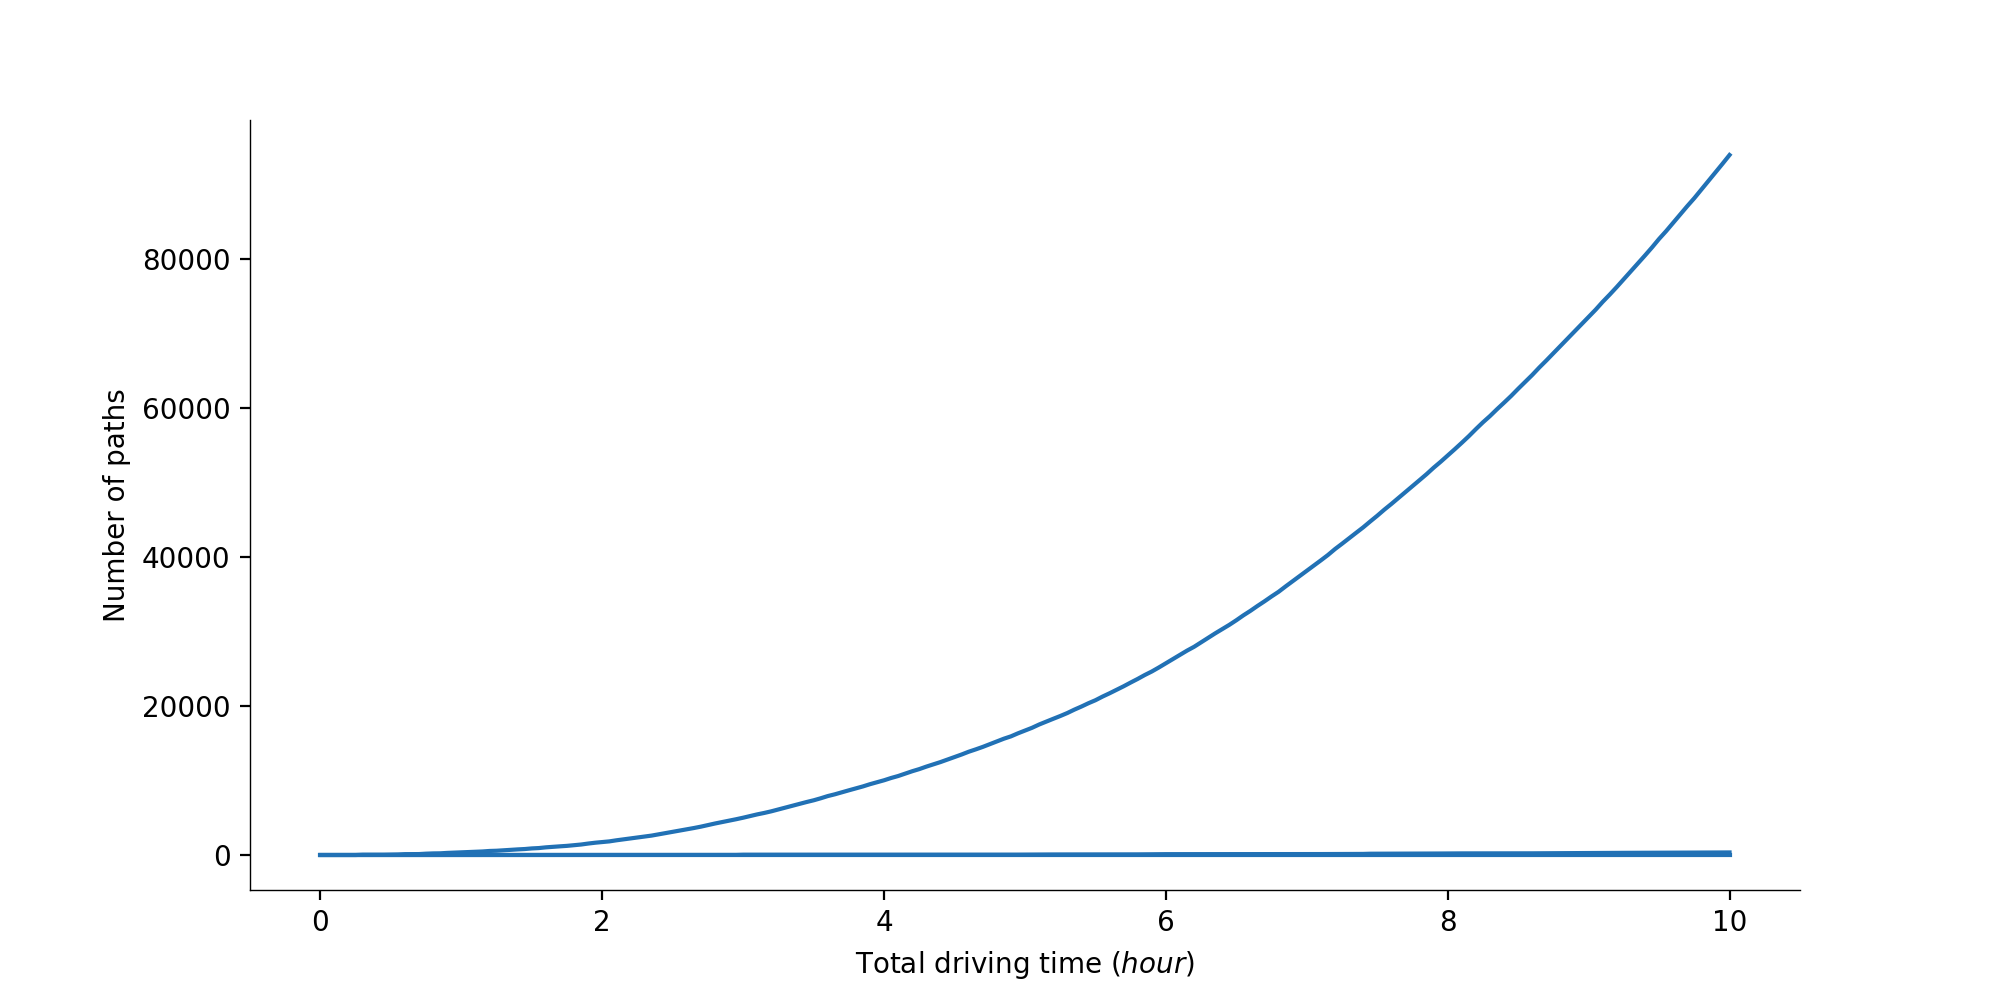

In [20]:
figure1 = plt.figure(figsize = (10, 5)) # 2.25
subfigure1 = figure1.add_subplot(111)

plt.plot(maximum_driving_times, list(zip(*reachable_features[0]))[0], '#2171b5')
plt.plot(maximum_driving_times, list(zip(*reachable_features[1]))[0], '#2171b5')
plt.plot(maximum_driving_times, list(zip(*reachable_features[2]))[0], '#2171b5')

plt.xlabel("Total driving time ($hour$)")
plt.ylabel("Number of paths")

# Thin the bottom and left axes lines ("spines")
subfigure1.spines['left'].set_linewidth(0.5)
subfigure1.spines['bottom'].set_linewidth(0.5)
# Remove top and right axes lines ("spines")
subfigure1.spines['right'].set_visible(False)
subfigure1.spines['top'].set_visible(False)

# Put the ticks outside
subfigure1.tick_params(direction='out')

# Only show ticks on the left and bottom spines
subfigure1.yaxis.set_ticks_position('left')
subfigure1.xaxis.set_ticks_position('bottom')

# subfigure1.set_yscale('log')

plt.show()

<IPython.core.display.Javascript object>


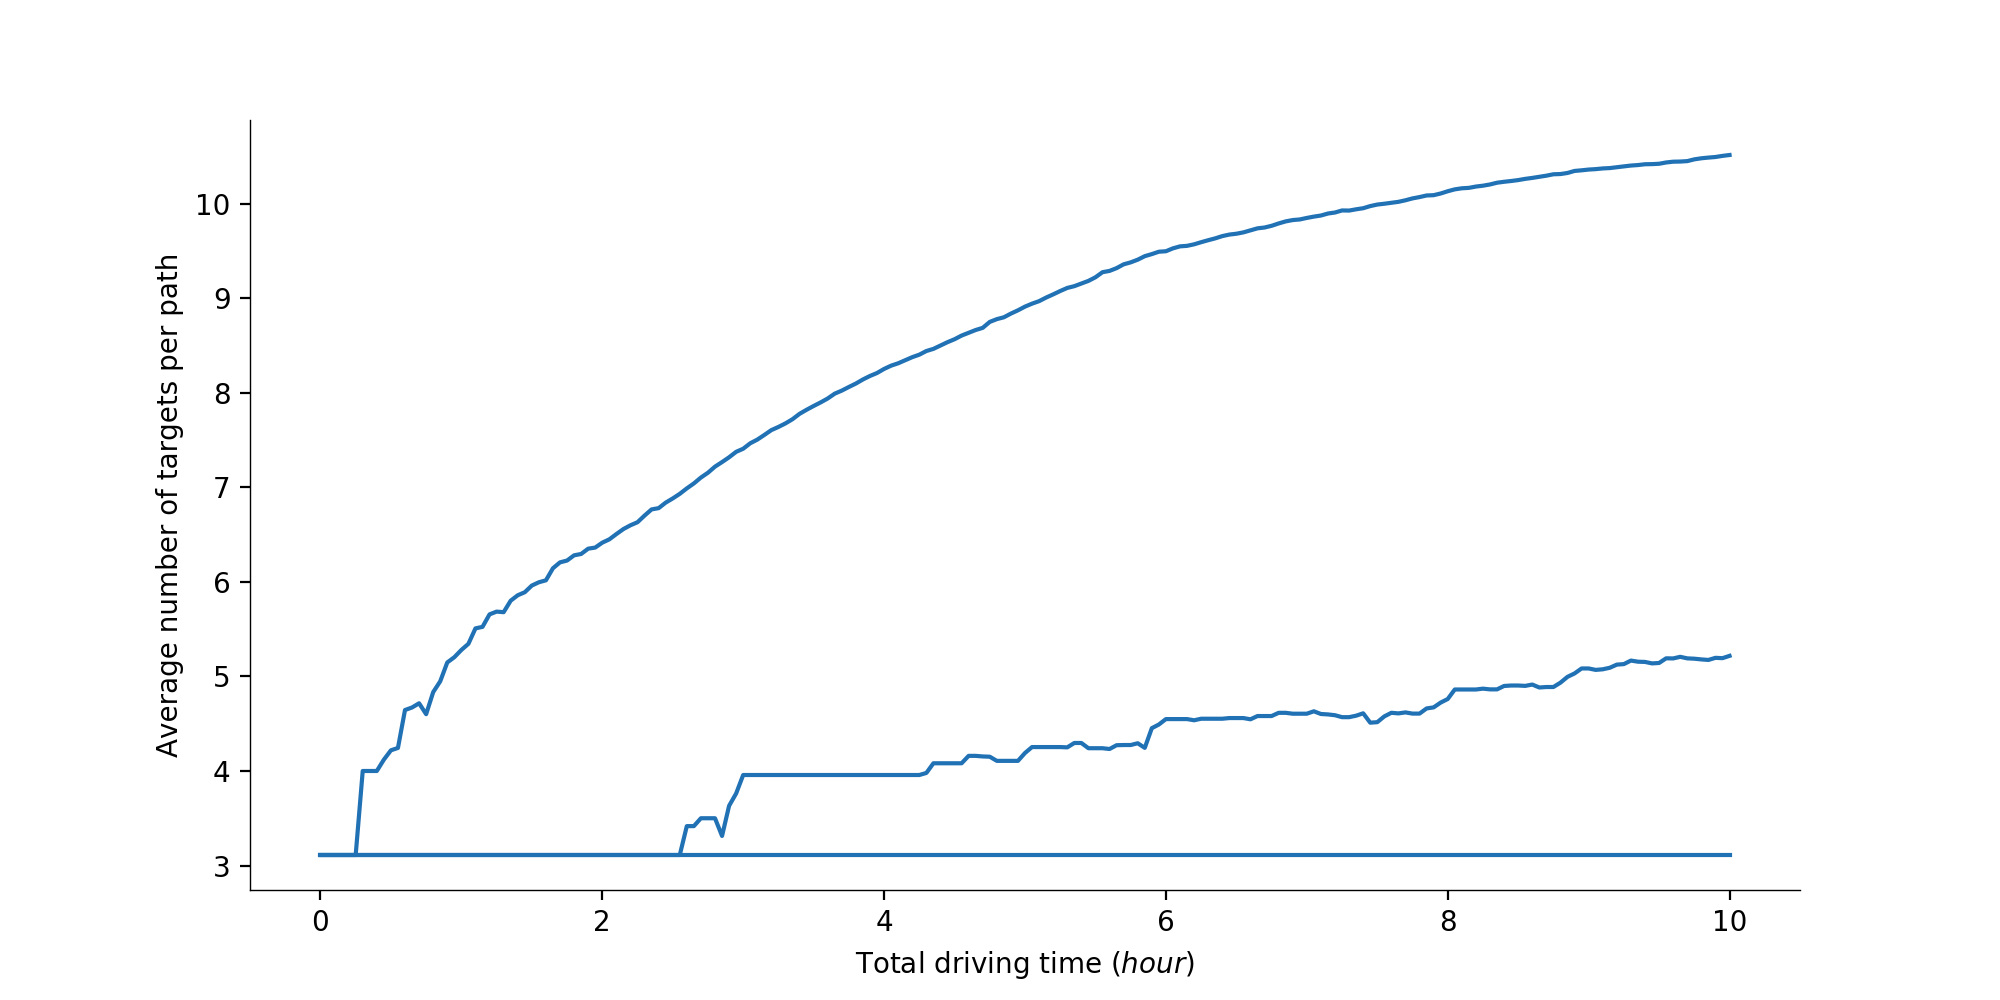

In [21]:
figure1 = plt.figure(figsize = (10, 5)) # 2.25
subfigure1 = figure1.add_subplot(111)

plt.plot(maximum_driving_times, list(zip(*reachable_features[0]))[1], '#2171b5')
plt.plot(maximum_driving_times, list(zip(*reachable_features[1]))[1], '#2171b5')
plt.plot(maximum_driving_times, list(zip(*reachable_features[2]))[1], '#2171b5')

plt.xlabel("Total driving time ($hour$)")
plt.ylabel("Average number of targets per path")

# Thin the bottom and left axes lines ("spines")
subfigure1.spines['left'].set_linewidth(0.5)
subfigure1.spines['bottom'].set_linewidth(0.5)
# Remove top and right axes lines ("spines")
subfigure1.spines['right'].set_visible(False)
subfigure1.spines['top'].set_visible(False)

# Put the ticks outside
subfigure1.tick_params(direction='out')

# Only show ticks on the left and bottom spines
subfigure1.yaxis.set_ticks_position('left')
subfigure1.xaxis.set_ticks_position('bottom')

# subfigure1.set_yscale('log')

plt.show()

We can print the plot values

In [22]:
plot = 0
factor = 1/10000.

string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[0]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + "%.4f"%factored_feature + ')'
print(string, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[1]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + "%.4f"%factored_feature + ')'
print(string, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[2]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + "%.4f"%factored_feature + ')'
print(string)

(0.00, 0.0009)(0.05, 0.0009)(0.10, 0.0009)(0.15, 0.0009)(0.20, 0.0009)(0.25, 0.0009)(0.30, 0.0009)(0.35, 0.0009)(0.40, 0.0009)(0.45, 0.0009)(0.50, 0.0009)(0.55, 0.0009)(0.60, 0.0009)(0.65, 0.0009)(0.70, 0.0009)(0.75, 0.0009)(0.80, 0.0009)(0.85, 0.0009)(0.90, 0.0009)(0.95, 0.0009)(1.00, 0.0009)(1.05, 0.0009)(1.10, 0.0009)(1.15, 0.0009)(1.20, 0.0009)(1.25, 0.0009)(1.30, 0.0009)(1.35, 0.0009)(1.40, 0.0009)(1.45, 0.0009)(1.50, 0.0009)(1.55, 0.0009)(1.60, 0.0009)(1.65, 0.0009)(1.70, 0.0009)(1.75, 0.0009)(1.80, 0.0009)(1.85, 0.0009)(1.90, 0.0009)(1.95, 0.0009)(2.00, 0.0009)(2.05, 0.0009)(2.10, 0.0009)(2.15, 0.0009)(2.20, 0.0009)(2.25, 0.0009)(2.30, 0.0009)(2.35, 0.0009)(2.40, 0.0009)(2.45, 0.0009)(2.50, 0.0009)(2.55, 0.0009)(2.60, 0.0009)(2.65, 0.0009)(2.70, 0.0009)(2.75, 0.0009)(2.80, 0.0009)(2.85, 0.0009)(2.90, 0.0009)(2.95, 0.0009)(3.00, 0.0009)(3.05, 0.0009)(3.10, 0.0009)(3.15, 0.0009)(3.20, 0.0009)(3.25, 0.0009)(3.30, 0.0009)(3.35, 0.0009)(3.40, 0.0009)(3.45, 0.0009)(3.50, 0.0009)(3.55,

In [23]:
plot = 1
factor = 1

string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[0]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + str(factored_feature) + ')'
print(string, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[1]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + str(factored_feature) + ')'
print(string, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
string = ''
for maximum_driving_time, reachable_feature in zip(maximum_driving_times,
                                               list(zip(*reachable_features[2]))[plot]):
    factored_feature = reachable_feature*factor
    string += '(' + "%.2f"%maximum_driving_time + ', ' + str(factored_feature) + ')'
print(string)

(0.00, 3.111111111111111)(0.05, 3.111111111111111)(0.10, 3.111111111111111)(0.15, 3.111111111111111)(0.20, 3.111111111111111)(0.25, 3.111111111111111)(0.30, 3.111111111111111)(0.35, 3.111111111111111)(0.40, 3.111111111111111)(0.45, 3.111111111111111)(0.50, 3.111111111111111)(0.55, 3.111111111111111)(0.60, 3.111111111111111)(0.65, 3.111111111111111)(0.70, 3.111111111111111)(0.75, 3.111111111111111)(0.80, 3.111111111111111)(0.85, 3.111111111111111)(0.90, 3.111111111111111)(0.95, 3.111111111111111)(1.00, 3.111111111111111)(1.05, 3.111111111111111)(1.10, 3.111111111111111)(1.15, 3.111111111111111)(1.20, 3.111111111111111)(1.25, 3.111111111111111)(1.30, 3.111111111111111)(1.35, 3.111111111111111)(1.40, 3.111111111111111)(1.45, 3.111111111111111)(1.50, 3.111111111111111)(1.55, 3.111111111111111)(1.60, 3.111111111111111)(1.65, 3.111111111111111)(1.70, 3.111111111111111)(1.75, 3.111111111111111)(1.80, 3.111111111111111)(1.85, 3.111111111111111)(1.90, 3.111111111111111)(1.95, 3.111111111111111)